In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
fichier_csv = 'Stage-3.csv'

df = pd.read_csv(fichier_csv)
df['vi'] = [0,200,200,300,200,0,300,200,200,200,200,200,200,200,200,200,0,200,200,200,200,200,200,200,200,200,200,200,0,0,0,0,300,300]
df['vf'] = [0,1100,800,600,700,0,600,1100,1100,800,1000,900,800,900,900,800,0,900,900,1100,1100,800,1100,1100,800,1100,1000,1000,0,0,0,0,1000,800]
df

Numéro  Position  Pression (Torr)  Ch. Magnétique (T) Gaz  \
0       33       0.0              0.0                 0.0  N2   
1       34       1.4              5.0                 0.0  N2   
2       35       2.0              5.0                 0.0  N2   
3       36       2.6              5.0                 0.0  N2   
4       37       1.4              5.0                 1.5  N2   
5       38       2.0              5.0                 1.5  N2   
6       39       2.6              5.0                 1.5  N2   
7       41       1.4              1.0                 0.0  N2   
8       42       2.0              1.0                 0.0  N2   
9       43       2.6              1.0                 0.0  N2   
10      44       1.4              1.0                 2.0  N2   
11      45       2.0              1.0                 2.0  N2   
12      46       2.6              1.0                 2.0  N2   
13      47       1.4              1.0                 2.0  N2   
14      48       2.0              1.0                 2.0  N2   
15      49       2.6              1.0                 2.0  N2   
16      51       1.4              1.0                 2.0  N2   
17      52       2.0              1.0                 2.0  N2   
18      53       2.6              1.0                 2.0  N2   
19      54       1.4              1.0                 0.0  N2   
20      55       2.0              1.0                 0.0  N2   
21      56       2.6              1.0                 0.0  N2   
22      57       1.4              1.0                 0.0  N2   
23      58       2.0              1.0                 0.0  N2   
24      59       2.6              1.0                 0.0  N2   
25      61       1.4              1.0                 0.0  N2   
26      62       2.0              1.0                 0.0  N2   
27      63       2.6              0.5                 0.0  N2   
28      64       1.4              0.5                 0.0  N2   
29      65       2.0              0.5                 0.0  N2   
30      66       2.6              0.5                 2.0  N2   
31      67       1.4              7.0                 2.0  He   
32      68       2.0              7.0                 0.0  He   
33      69       2.6              7.0                 2.0  He   

    Laser Energy (J)   vi    vf  
0               2892    0     0  
1               2700  200  1100  
2               2842  200   800  
3               2727  300   600  
4               2662  200   700  
5               2682    0     0  
6               2655  300   600  
7               2717  200  1100  
8               2773  200  1100  
9               2715  200   800  
10              2712  200  1000  
11              2662  200   900  
12              2657  200   800  
13              2649  200   900  
14              2548  200   900  
15              2637  200   800  
16              2757    0     0  
17              2775  200   900  
18              2695  200   900  
19              2699  200  1100  
20              2705  200  1100  
21              2631  200   800  
22              2627  200  1100  
23              2679  200  1100  
24              2543  200   800  
25              2690  200  1100  
26              2693  200  1000  
27              2688  200  1000  
28              2636    0     0  
29              2689    0     0  
30              2588    0     0  
31              2591    0     0  
32              2616  300  1000  
33              2582  300   800

In [106]:
def load_image(file_path) :
    img = Image.open(file_path)
    img_data = np.array(img)
    return img_data

def pix_to_t(t, tf, ti) :
    return (tf-ti) / 1016 * t + ti

def pix_to_x(x, xf, xi) :
    return (xf-xi) / 1344 * x + xi

def fitpow(x, a, b) : 
    return a * np.abs(x) ** b

def fitlin_ab(x, a, b) :
    return a * x + b

def fitlin_a(x, a) :
    return a * x

def vitesse(x, a, b) :
    return (a * b) * x ** (b-1)

In [126]:
def graph(n, data, v) :

    FLIP = True
    if n >= 16 :
        FLIP = False

    ligne_num = n
    if ligne_num >= 16 :
        FLIP = False
    ligne = data.iloc[ligne_num]

    position = ligne['Position']
    numero = int(ligne['Numéro'])
    gaz = ligne['Gaz']
    p = ligne['Pression (Torr)']
    B = ligne['Ch. Magnétique (T)']
    vi, vf = ligne['vi'], ligne['vf']
    if vi == 0 and vf == 0 :
        return 0, 0, 0, 0, 0, 0
    
    file_path =  f"../Stage_Pic/477{numero}.tif"
    img_data = load_image(file_path)

    ti, tf = -26.67, 73.1

    if position == 1.4:
        xi, xf = 0.3, 2.6
    elif position == 2:
        xi, xf = 0.9, 3.32
    elif position == 2.6:
        xi, xf = 1.5, 3.9
    else:
        return 0, 0, 0, 0, 0, 0
    
    if gaz == 'N2' :
        c = 0.33696
    elif gaz == 'He' :
        c = 1.020
    else :
        c = 0

    if FLIP == True : 
        img_data = np.flip(img_data, axis = 0)

    x = np.linspace(0,1344,1344)

    P_max = []

    for ligne in img_data : 
        P_max.append(np.where(ligne == max(ligne))[0][0])
    pts = np.array(P_max)
    
    x_filtre = x[vi:vf]
    pts_filtre = np.flip(pts)[vi:vf]
    
    x_conv = pix_to_x(x_filtre, xf, xi)
    t_conv = pix_to_t(pts_filtre, tf, ti)
    
    p0, var0 = curve_fit(fitpow, t_conv, x_conv, maxfev = 100000)
    a0, b0 = p0

    t_fin = np.linspace(ti,tf,1016)
    x_pow = fitpow(t_fin, a0, b0)
    
    i, j = 0,0

    while x_pow[i+1] < x_pow[i] or x_pow[i] < xi :
        i += 1
    while x_pow[j] <= xf :
        j += 1
        if j == 1016 :
            break
    
    if v == True :
        plt.figure(figsize=(7, 5))
        plt.imshow(img_data,
                   cmap='viridis',
                   extent=[ti, tf, xi, xf],
                   aspect='auto',
                   vmax=np.max(img_data))
        plt.grid()
        plt.plot(t_fin[i:j], x_pow[i:j], color = '#ff0000', label = 'Ajustement at^b, a = ' + str(a0)[:5] + ', b  = ' + str(b0)[:5])
        plt.xlabel('t (ns)')
        plt.ylabel('x (cm)')
        plt.title(f'Shot n°{numero}, P = {p} Torr, B = {B} T, {gaz}')
        plt.legend()
        plt.show()
    
    return a0, b0, p, B, t_fin, x_pow

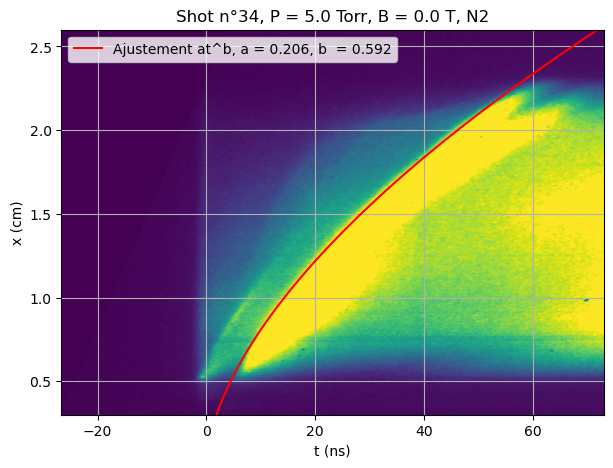

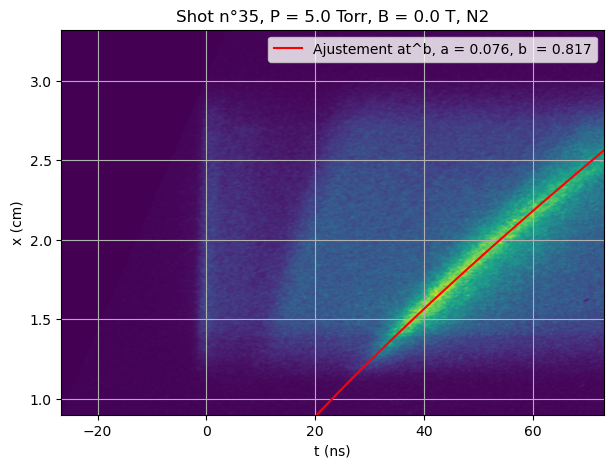

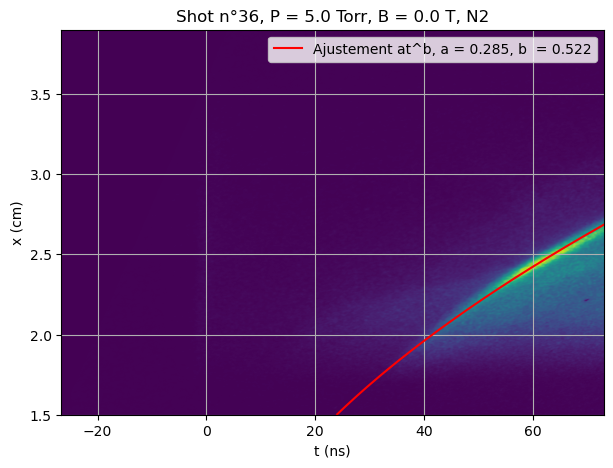

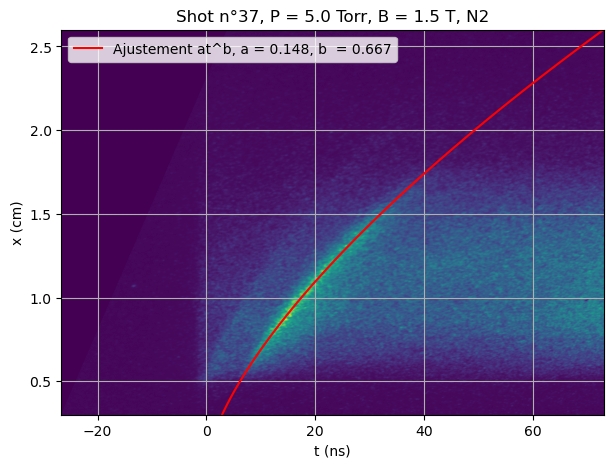

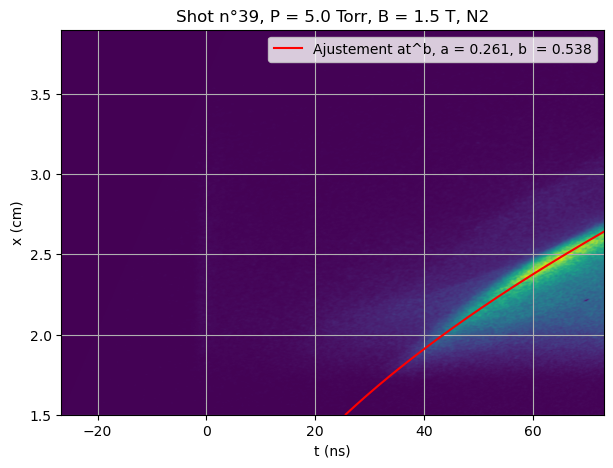

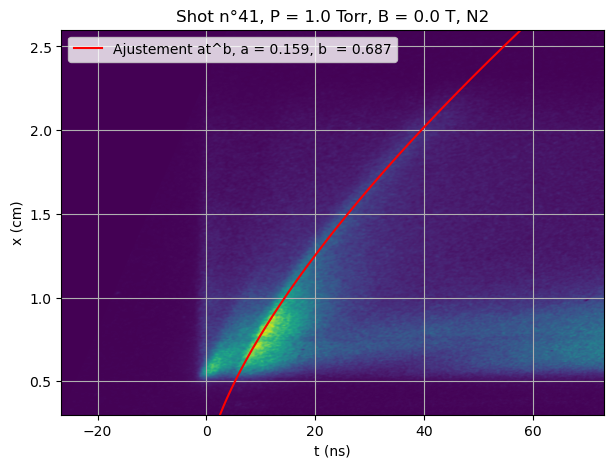

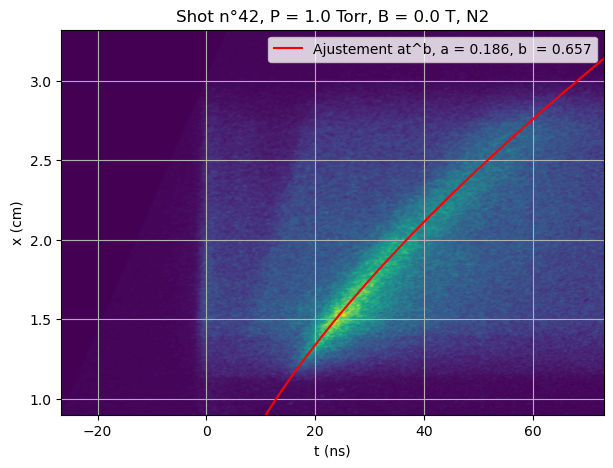

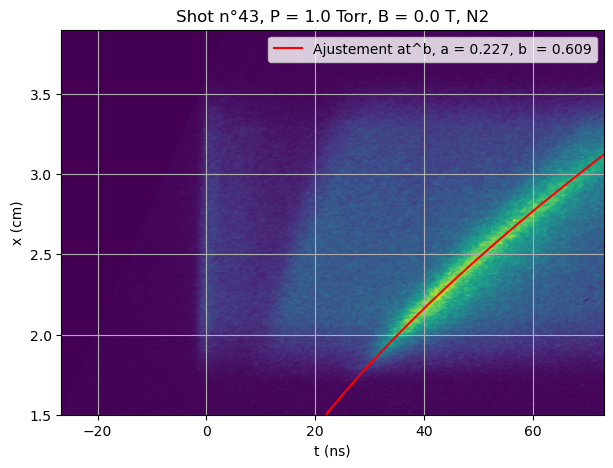

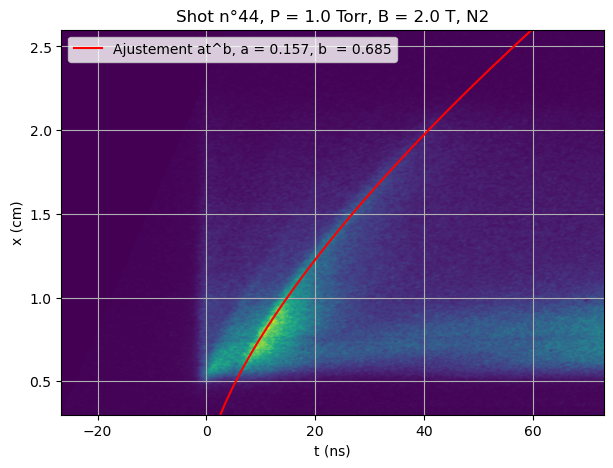

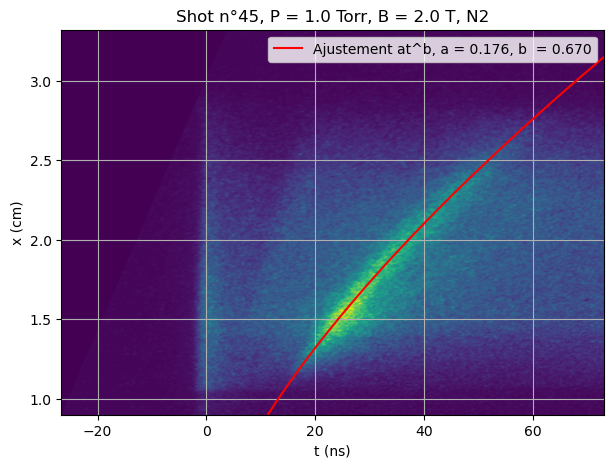

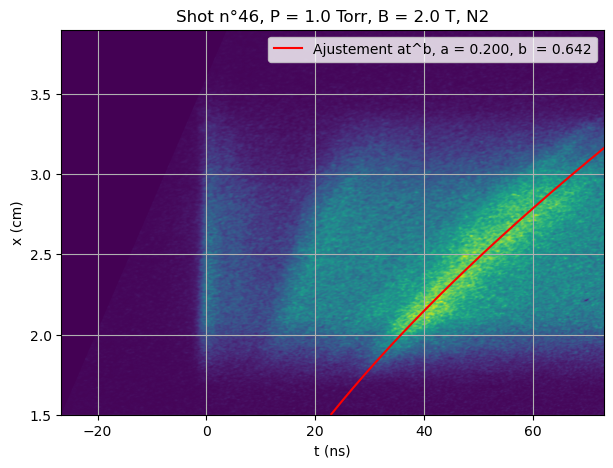

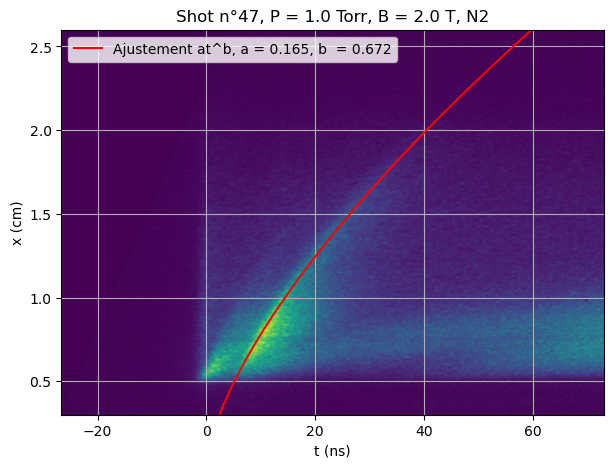

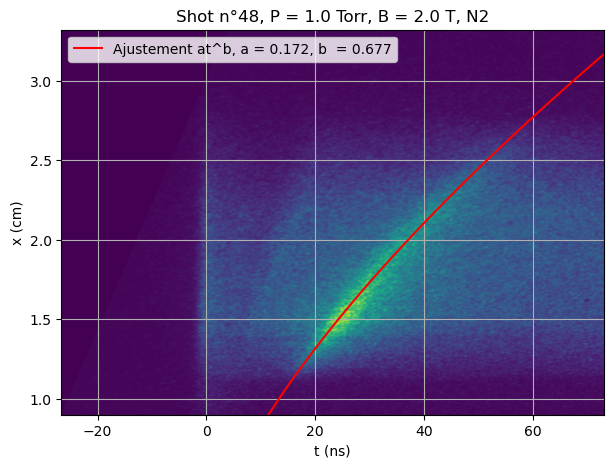

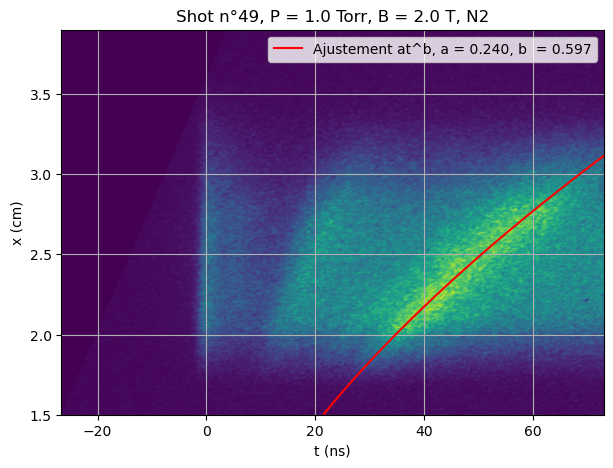

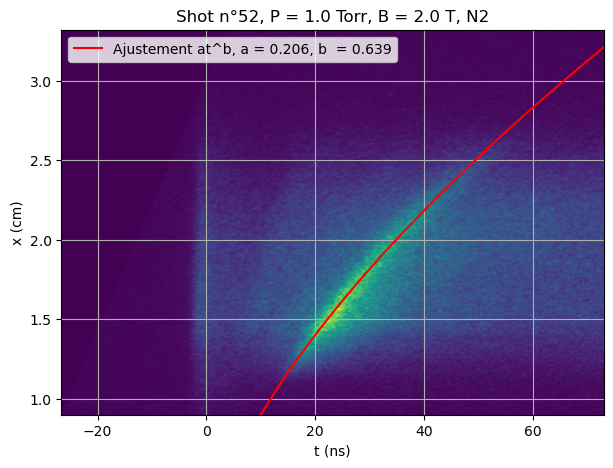

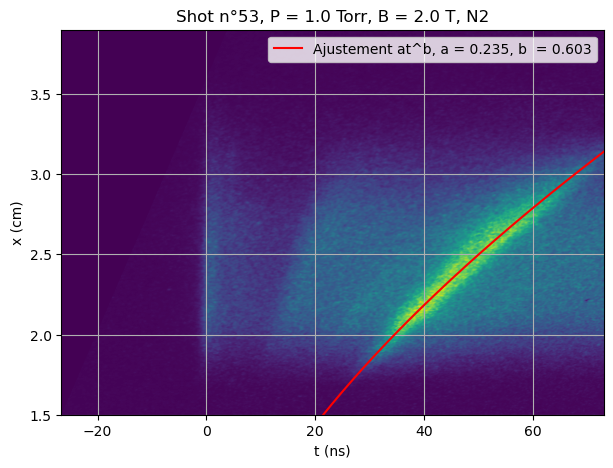

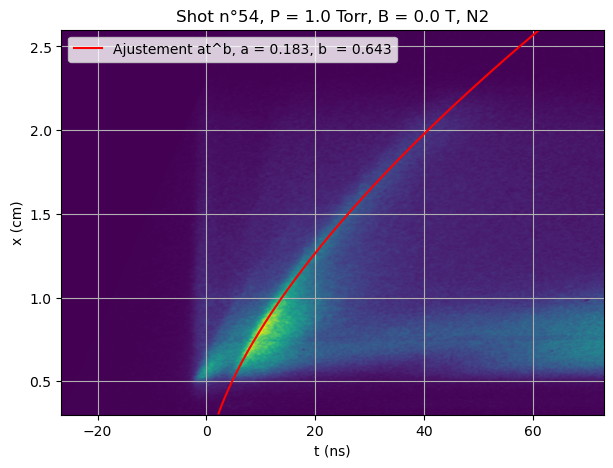

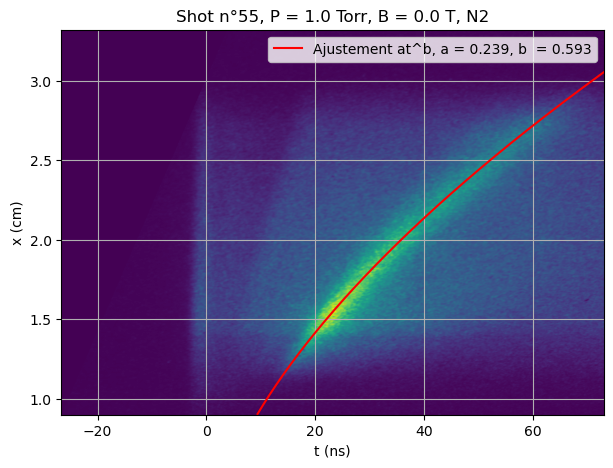

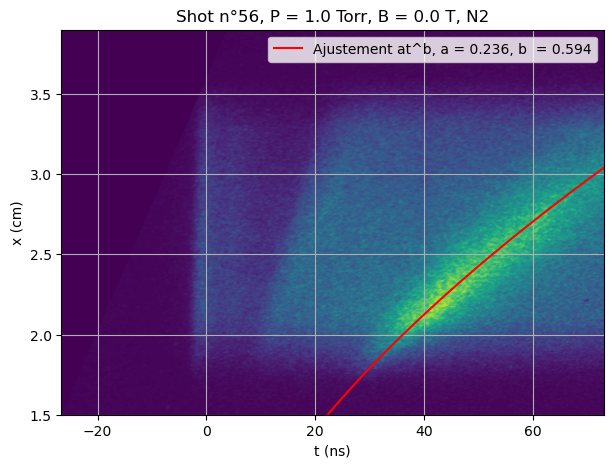

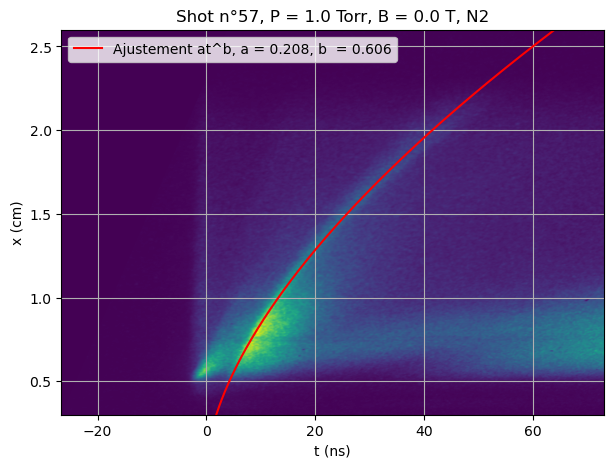

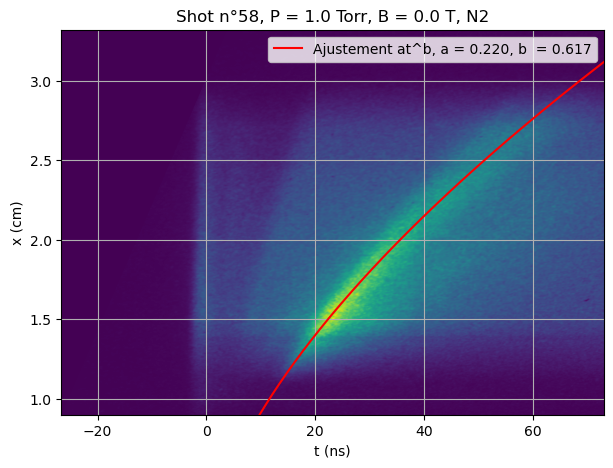

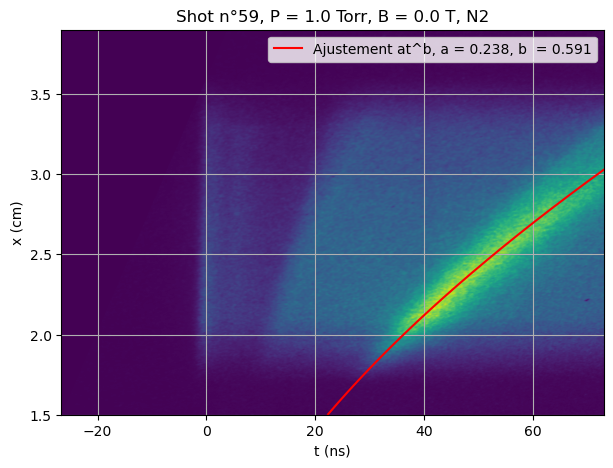

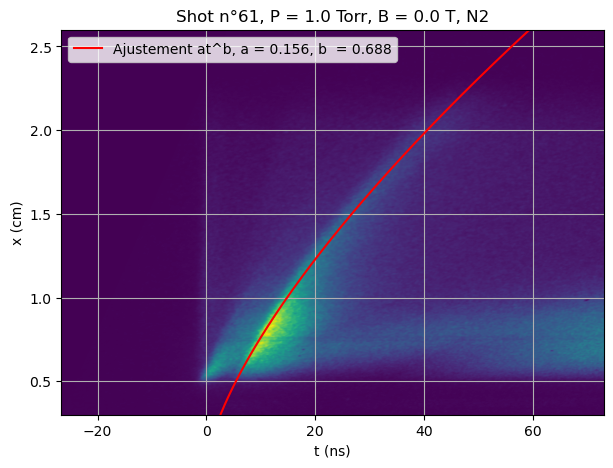

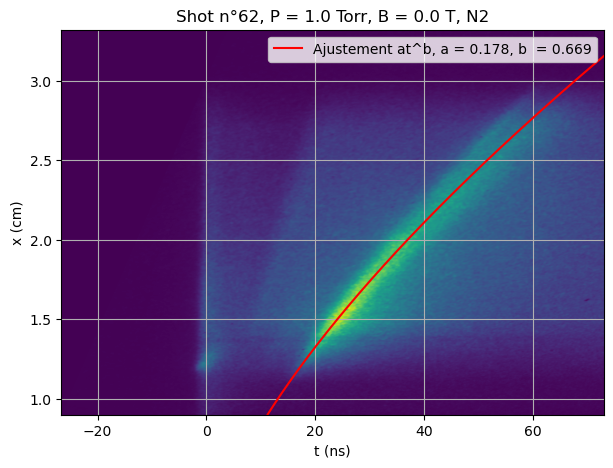

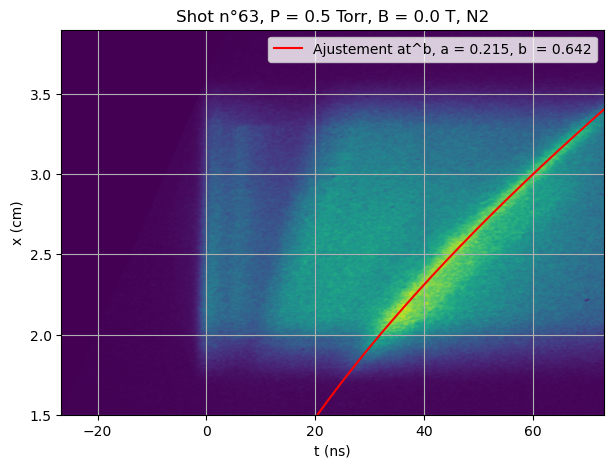

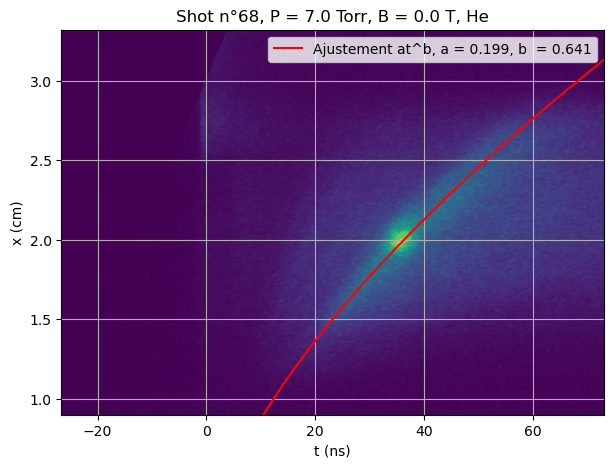

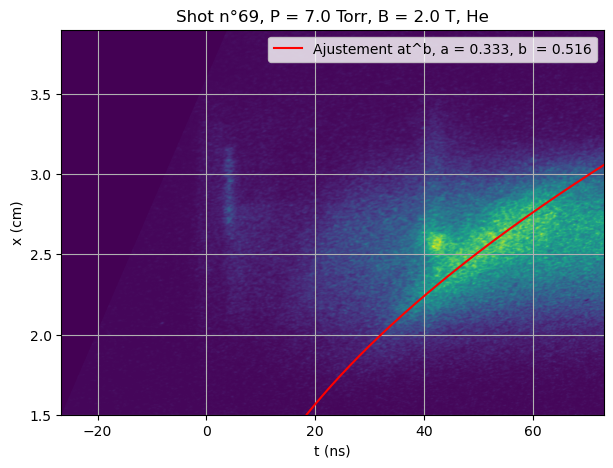

In [127]:
for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, True)

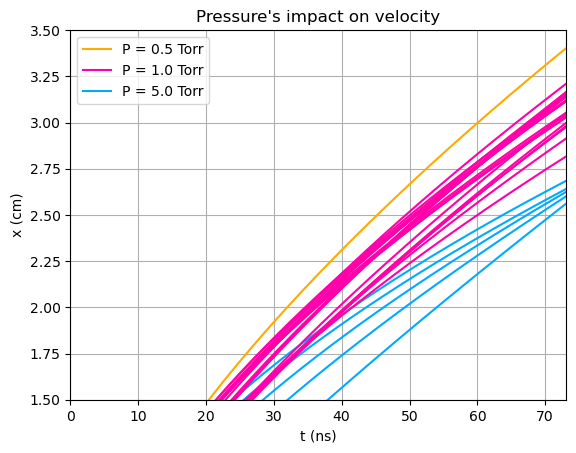

In [123]:
plt.plot(0, 0, color = "#ffaa00", label = 'P = 0.5 Torr')
plt.plot(0, 0, color = "#ff00aa", label = 'P = 1.0 Torr')
plt.plot(0, 0, color = "#00aaff", label = 'P = 5.0 Torr')

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if df['Gaz'][i] != 'He' :
        if p == 0 :
            C = "#ffffff"
        if p == 0.5 :
            C = "#ffaa00"
        if p == 1 :
            C = "#ff00aa"
        if p == 5 :
            C = "#00aaff"
        plt.plot(tc, xc, color = C)

plt.xlim(0,73.1)
plt.ylim(1.5,3.5)
plt.xlabel('t (ns)')
plt.ylabel('x (cm)')
plt.grid()
plt.legend()
plt.title("Pressure's impact on velocity")
plt.show()

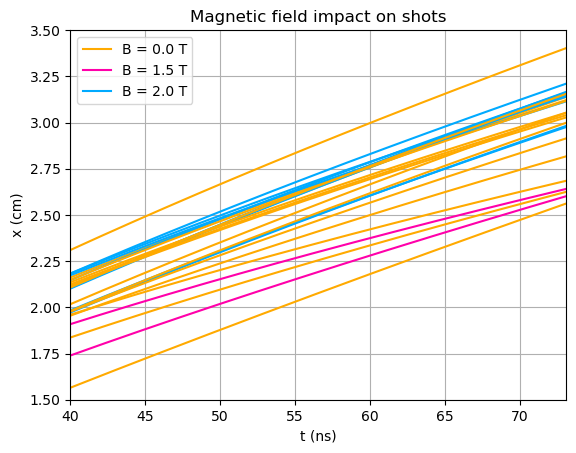

In [116]:
plt.plot(0, 0, color = "#ffaa00", label = 'B = 0.0 T')
plt.plot(0, 0, color = "#ff00aa", label = 'B = 1.5 T')
plt.plot(0, 0, color = "#00aaff", label = 'B = 2.0 T')

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if df['Gaz'][i] != 'He' :
        if B == 0 :
            C = "#ffaa00"
        if B == 1.5 :
            C = "#ff00aa"
        if B == 2 :
            C = "#00aaff"
        plt.plot(tc, xc, color = C)

plt.xlim(40,73.1)
plt.ylim(1.5,3.5)
plt.xlabel('t (ns)')
plt.ylabel('x (cm)')
plt.grid()
plt.legend()
plt.title('Magnetic field impact on shots')
plt.show()

- laser energy as a function of $ba$ / $b-1$ / $a$
- pressure as a function of $b$
- b as a function of the Thompson Scattering

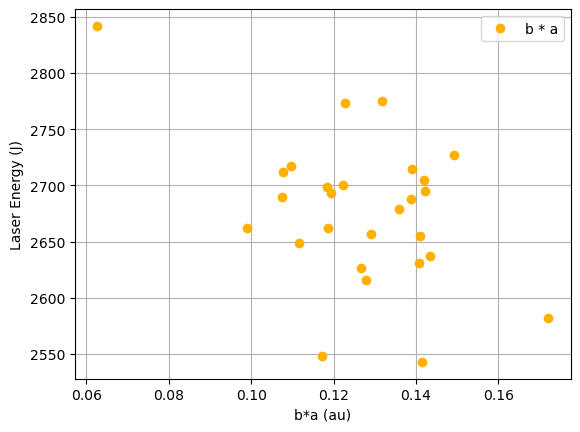

In [129]:
lab, lE = [], []

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if a != 0 :
        E = df['Laser Energy (J)'][i]
        if i == 1 :
            plt.plot(b*a, E, 'o', color = "#ffb000", label = "b * a")
        else :
            plt.plot(b*a, E, 'o', color = "#ffb000")
        lab.append(a*b)
        lE.append(E)
            
p0, var = curve_fit(fitlin_ab, lab, lE)
a0, b0 = p0

#plt.plot(np.linspace(0, 1300, 1000), fitlin_ab(np.linspace(0, 1300, 1000), a0, b0), color = "#00b0ff")            
            
plt.xlabel('b*a (au)')
plt.ylabel('Laser Energy (J)')
plt.grid()
plt.legend()
plt.show()

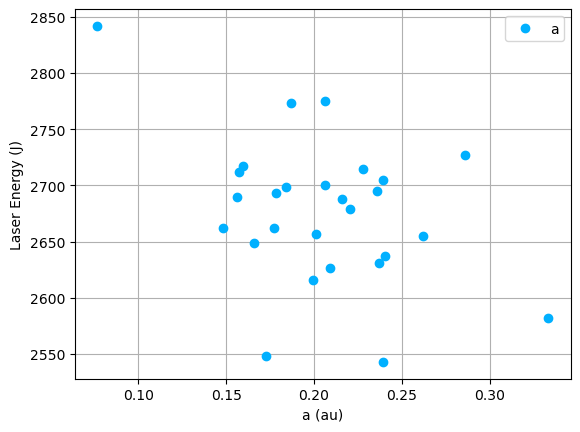

In [133]:
for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if a != 0 :
        E = df['Laser Energy (J)'][i]
        if i == 1 :
            plt.plot(a, E, 'o', color = "#00b0ff", label = "a")
        else :
            plt.plot(a, E, 'o', color = "#00b0ff")


plt.xlabel('a (au)')
plt.ylabel('Laser Energy (J)')
plt.grid()
plt.legend()
plt.show()

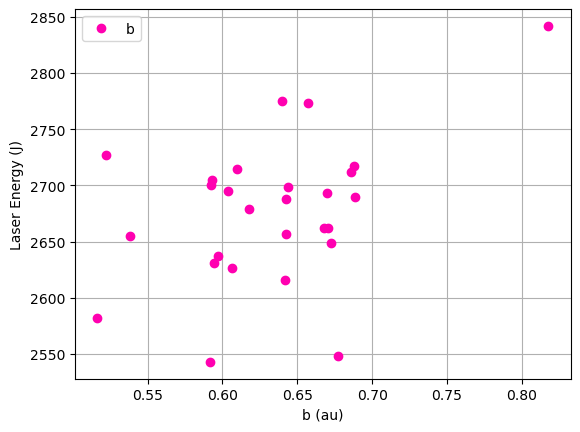

In [134]:
for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if b != 0 :
        E = df['Laser Energy (J)'][i]
        if i == 1 :
            plt.plot(b, E, 'o', color = "#ff00b0", label = "b")
        else :
            plt.plot(b, E, 'o', color = "#ff00b0")
      

plt.xlabel('b (au)')
plt.ylabel('Laser Energy (J)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
lb, lp = [], []

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if b != 0 :
        if i == 1 :
            plt.plot(b, p, 'o', color = "#ffb000", label = "b")
        else :
            plt.plot(b, p, 'o', color = "#ffb000")
        lb.append(b)
        lp.append(p)
            
p0, var = curve_fit(fitlin_ab, lb, lp)
a0, b0 = p0

#plt.plot(np.linspace(0, 1300, 1000), fitlin_ab(np.linspace(0, 1300, 1000), a0, b0), color = "#00b0ff")            
            
#plt.xlim(0,1300)
#plt.ylim(2400,2900)
plt.xlabel('b (au)')
plt.ylabel('P (Torr)')
plt.grid()
plt.legend()
plt.show()

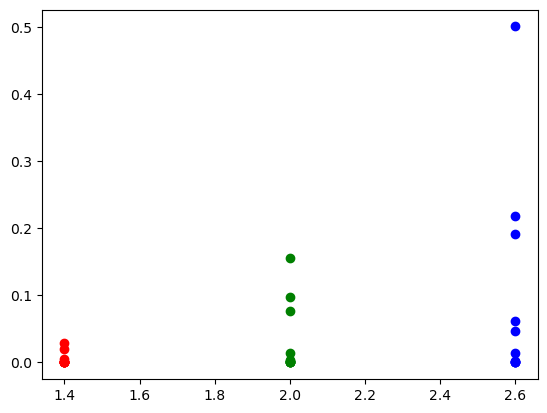

In [84]:
l14, l20, l26 = [], [], []

for i in range(34) :
    a, b, p, B, xc, tc = graph(i, df, False)
    Tx = df['Position'][i]
    if Tx == 1.4 :
        l14.append(b) 
        plt.plot(1.4, b, 'o', color = 'r')
    if Tx == 2 :
        l20.append(b) 
        plt.plot(2, b, 'o', color = 'g')
    if Tx == 2.6 :
        l26.append(b) 
        plt.plot(2.6, b, 'o', color = 'b')
        
b14, b20, b26 = np.mean(l14), np.mean(l20), np.mean(l26)
plt.plot(